# Introdução a Modulação Digital com Áudio / Matheus Galdino de Souza - 123111147

⚠️ Esse codigo não funciona em maquinas virtuais ou no WSL


Sobre esse Laboratório:

- [Setup](#setup)
- [Parametros e Bibliotecas](#parametros-de-configurações)
- [Funções e Metodos](#funções)
- [O Laboratório](#o-laboratório)
    1. [Etapa 1: Compreendendo com a Codificação/Modulação de dados](#etapa-1-compreendendo-com-a-codificaçãomodulação-de-dados)
    1. [Etapa 2: Decodificação](#etapa-2-decodificação)
    1. [Etapa 3: Impacto do Ruído na Comunicação](#etapa-3-impacto-do-ruído-na-comunicação)
    1. [Etapa 4: Decodificação no mundo real](#etapa-4-decodificação-no-mundo-real)



## Setup

⚠️ **Atenção** : Execute o código abaixo **apenas uma vez** para realizar a configuração inicial do ambiente.

In [308]:
!pip install numpy matplotlib soundfile sounddevice scipy


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Escolhendo a saida e entrada de audio

In [309]:
import os

import sounddevice as sd
import numpy as np
from scipy.io import wavfile

O comando `sd.query_devices()` listará todas as **entradas** e **saídas** de áudio disponíveis no seu computador. 

A partir dessa lista, identifique qual é a sua **entrada** (microfone) e **saída** (alto-falante) de áudio desejada e atribua esses valores às variáveis `input_device` e `output_device`, respectivamente. Por exemplo,

```
  0 Mapeador de som da Microsoft - Input, MME (2 in, 0 out)
>  1 Digital Microphone (2- Cirrus L, MME (2 in, 0 out)
   2 Mapeador de som da Microsoft - Output, MME (0 in, 2 out)
<  3 Alto-falantes (2- Cirrus Logic , MME (0 in, 2 out)
   4 Driver de captura de som primário, Windows DirectSound (2 in, 0 out)
   5 Digital Microphone (2- Cirrus Logic High Definition Audio), Windows DirectSound (2 in, 0 out)
   6 Driver de som primário, Windows DirectSound (0 in, 2 out)
   7 Alto-falantes (2- Cirrus Logic High Definition Audio), Windows DirectSound (0 in, 2 out)
   8 Alto-falantes (2- Cirrus Logic High Definition Audio), Windows WASAPI (0 in, 2 out)
```

Para que o laboratorio funcione adequamente no meu computador devo escolher opcoes 1 , 3.

In [310]:
sd.query_devices()

   0 Mapeador de som da Microsoft - Input, MME (2 in, 0 out)
>  1 Digital Microphone (2- Cirrus L, MME (2 in, 0 out)
   2 Mapeador de som da Microsoft - Output, MME (0 in, 2 out)
<  3 Alto-falantes (2- Cirrus Logic , MME (0 in, 2 out)
   4 Driver de captura de som primário, Windows DirectSound (2 in, 0 out)
   5 Digital Microphone (2- Cirrus Logic High Definition Audio), Windows DirectSound (2 in, 0 out)
   6 Driver de som primário, Windows DirectSound (0 in, 2 out)
   7 Alto-falantes (2- Cirrus Logic High Definition Audio), Windows DirectSound (0 in, 2 out)
   8 Alto-falantes (2- Cirrus Logic High Definition Audio), Windows WASAPI (0 in, 2 out)
   9 Digital Microphone (2- Cirrus Logic High Definition Audio), Windows WASAPI (2 in, 0 out)
  10 Digital Microphone (AudioMiniport Wave Microphone Front), Windows WDM-KS (2 in, 0 out)
  11 Output 1 (AudioMiniport Wave Speaker), Windows WDM-KS (0 in, 2 out)
  12 Output 2 (AudioMiniport Wave Speaker), Windows WDM-KS (0 in, 2 out)
  13 Input (Au

In [311]:
output_device = 3
input_device = 1
sd.default.device = (input_device, output_device)

🎯 Execute o código abaixo para gravar um áudio de 3 segundos e, em seguida, reproduzi-lo.

Caso a gravação ou reprodução não funcione corretamente, ajuste os valores das variáveis `input_device` (dispositivo de entrada) e `output_device` (dispositivo de saída) até que o código funcione como esperado.

In [312]:
DURATION = 3  # duraçao em segundos
SAMPLE_RATE = 44100  # Hz
FILENAME = "captura.wav"

audio = sd.rec(int(DURATION * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1, dtype='float32')
sd.wait()
print("Gravação finalizada.")

# Salvando arquivo de audio temporario
max_val = np.max(np.abs(audio))
if max_val > 0:
    scaled = audio / max_val
else:
    scaled = audio
wav_data = np.int16(scaled * 32767)
wavfile.write(FILENAME, SAMPLE_RATE, wav_data)
print(f"Áudio salvo em {FILENAME}")

# Reproduz o áudio salvo
fs, data = wavfile.read(FILENAME)
sd.play(data, fs)
sd.wait()
os.remove(FILENAME)
print('Se você escutou o audio tudo seu sistema está configurado corretamente!')

Gravação finalizada.
Áudio salvo em captura.wav
Se você escutou o audio tudo seu sistema está configurado corretamente!


## Parametros de configurações

In [313]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
from scipy import signal
from scipy.io import wavfile
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
import time
import os

Parametros de codificação

In [314]:
##
## Configurações globais do exercio
##
SAMPLE_RATE = 44100  # Taxa de amostragem do audio
BIT_DURATION = 1.0   # 1 segundo por bit
FREQ_LOW = 440       # bit '0' (Lá)
FREQ_HIGH = 880      # bit '1' (Lá oitava)

## Funções

Nessa secao vocês encontraram as funcoes utilizadas

### Gerador de tom & visualizacao

In [315]:
def generate_tone(frequency, duration, sample_rate=SAMPLE_RATE):
    """
    Gera um tom senoidal
    
    Args:
        frequency: Frequência em Hz
        duration: Duração em segundos
        sample_rate: Taxa de amostragem
    
    Returns:
        array: Sinal de áudio
    """
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    # Aplica janela para suavizar transições
    tone = np.sin(2 * np.pi * frequency * t)
    # Janela de Hanning para evitar cliques
    window = np.hanning(len(tone))
    return tone * window

In [316]:
def show(data:str,debug):
    if debug==True:
        print(data)

In [317]:
def plot_signal(audio_signal, title, num_bits):
    time_axis = np.linspace(0, len(audio_signal)/SAMPLE_RATE, len(audio_signal))
    
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, audio_signal)
    plt.title(title)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    for i in range(1, num_bits): #divisões dos bits
        plt.axvline(x=i*BIT_DURATION, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

### Codificadores

In [318]:
def encode_nrz(data_bits,debug=False):
    """
    Codifica dados usando NRZ
    
    Args:
        data_bits: string de bits (ex: "10110")
    
    Returns:
        array: Sinal de áudio codificado
    """
    audio_signal = np.array([])
    
    show(f"Codificando NRZ: {data_bits}",debug)
    
    for i, bit in enumerate(data_bits):
        if bit == '1':
            freq = FREQ_HIGH
            show(f"Bit {i}: '1' -> {freq} Hz",debug)
        else:
            freq = FREQ_LOW
            show(f"Bit {i}: '0' -> {freq} Hz",debug)
        
        tone = generate_tone(freq, BIT_DURATION)
        audio_signal = np.concatenate([audio_signal, tone])
    
    return audio_signal

In [319]:
def encode_manchester(data_bits,debug=False):
    """
    Codifica dados usando Manchester
    
    Args:
        data_bits: string de bits
    
    Returns:
        array: Sinal de áudio codificado
    """
    audio_signal = np.array([])
    
    show(f"Codificando Manchester: {data_bits}",debug)
    
    for i, bit in enumerate(data_bits):
        if bit == '1':
            # Bit '1': alto->baixo (primeira metade alta, segunda baixa)
            tone1 = generate_tone(FREQ_HIGH, BIT_DURATION/2)
            tone2 = generate_tone(FREQ_LOW, BIT_DURATION/2)
            show(f"Bit {i}: '1' -> {FREQ_HIGH}Hz -> {FREQ_LOW}Hz",debug)
        else:
            # Bit '0': baixo->alto (primeira metade baixa, segunda alta)
            tone1 = generate_tone(FREQ_LOW, BIT_DURATION/2)
            tone2 = generate_tone(FREQ_HIGH, BIT_DURATION/2)
            show(f"Bit {i}: '0' -> {FREQ_LOW}Hz -> {FREQ_HIGH}Hz",debug)
        
        bit_signal = np.concatenate([tone1, tone2])
        audio_signal = np.concatenate([audio_signal, bit_signal])
    
    return audio_signal

### Decodificadores

In [320]:
def estimate_tone_freqs(x, sr):
    N = min(len(x), sr*10)
    X = np.abs(fft(x[:N])[:N//2])
    freqs = fftfreq(N, 1.0/sr)[:N//2]

    mask = (freqs > 300) & (freqs < sr/2 - 1000)
    freqs_masked = freqs[mask]
    X_masked = X[mask]

    peaks, _ = find_peaks(X_masked, distance=20)
    if len(peaks) < 2:
        idx = np.argsort(X_masked)[-2:]
    else:
        idx = peaks[np.argsort(X_masked[peaks])[-2:]]

    est = np.sort(freqs_masked[idx])
    return float(est[0]), float(est[1])

In [321]:
def short_time_tone_energy(x, sr, f, win_len=0.01, hop=0.002):
    nwin = int(win_len*sr)
    hopn = int(hop*sr)
    if nwin < 8: nwin = 8
    if hopn < 1: hopn = 1

    times = []
    energy = []

    t0 = 0
    while t0 + nwin <= len(x):
        w = x[t0:t0+nwin] * np.hanning(nwin)
        tt = np.arange(t0, t0+nwin) / sr
        s = np.sin(2*np.pi*f*tt)
        c = np.cos(2*np.pi*f*tt)
        e = (np.dot(w, s)**2 + np.dot(w, c)**2) / nwin

        energy.append(e)
        times.append((t0 + nwin/2)/sr)
        t0 += hopn

    return np.array(times), np.array(energy)

In [322]:
def decode_bits_from_symbol_series(times, symbol_vals, estimated_baud):
    bit_dur = 1.0 / estimated_baud
    t_start = times[0] - bit_dur * 0.5
    t_end = times[-1] + (times[1] - times[0]) * 0.5

    nb = int(np.floor((t_end - t_start) / bit_dur))
    bits = []
    bit_times = []

    for i in range(nb):
        bs = t_start + i * bit_dur
        be = bs + bit_dur
        mask = (times >= bs) & (times < be)

        if np.sum(mask) == 0:
            bits.append(0)
        else:
            bits.append(int(np.mean(symbol_vals[mask]) > 0.5))

        bit_times.append(bs + bit_dur/2)

    return np.array(bits), np.array(bit_times), bit_dur

In [323]:
def analyze_signal(x, sr, show_plots=True, title_suffix="", save_bin=True):
    x = x.astype(np.float32)
    x = x / (np.max(np.abs(x)) + 1e-12)

    f0, f1 = estimate_tone_freqs(x, sr)

    t0, E0 = short_time_tone_energy(x, sr, f0)
    t1, E1 = short_time_tone_energy(x, sr, f1)

    times = t0
    diff = E1 - E0
    symbol = (diff > 0).astype(int)

    N = len(diff)
    sample_rate_st = 1.0/(times[1]-times[0])
    Y = np.abs(fft(diff - np.mean(diff)))
    freqs = fftfreq(N, 1.0/sample_rate_st)
    mask = (freqs > 0.5) & (freqs < sample_rate_st/2)

    if np.any(mask):
        idx = np.argmax(Y[mask])
        est_baud = max(1.0, round(freqs[mask][idx]))
    else:
        est_baud = 100.0

    bits, bit_times, bit_dur = decode_bits_from_symbol_series(times, symbol, est_baud)

    mid_checks = []
    for i, bt in enumerate(bit_times):
        bs = bt - bit_dur/2
        mid = bt
        be = bt + bit_dur/2

        mask_first = (times>=bs) & (times<mid)
        mask_second = (times>=mid) & (times<be)

        if np.sum(mask_first)==0 or np.sum(mask_second)==0:
            mid_checks.append(0)
            continue

        v_first = np.mean(symbol[mask_first])
        v_second = np.mean(symbol[mask_second])

        mid_checks.append(int(abs(v_first - v_second) > 0.4))

    mid_checks = np.array(mid_checks)
    encoding = "manchester" if np.mean(mid_checks) > 0.4 else "nrz"

In [324]:
def analyze_file(path):
    sr, x = wavfile.read(path)

    if x.ndim > 1:
        x = x.mean(axis=1)

    x = x.astype(np.float32)
    x /= np.max(np.abs(x)) + 1e-12

    f0, f1 = estimate_tone_freqs(x, sr)

    t0, E0 = short_time_tone_energy(x, sr, f0)
    t1, E1 = short_time_tone_energy(x, sr, f1)

    times = t0
    diff = E1 - E0
    symbols = (diff > 0).astype(int)

    N = len(diff)
    sample_rate_st = 1.0 / (times[1] - times[0])

    Y = np.abs(fft(diff - np.mean(diff)))
    freqs = fftfreq(N, 1.0/sample_rate_st)

    mask = (freqs > 0.5) & (freqs < sample_rate_st/2)

    if np.any(mask):
        idx = np.argmax(Y[mask])
        baud = max(1, round(freqs[mask][idx]))
    else:
        baud = 100  # fallback

    bits, bit_times, bit_dur = decode_bits_from_symbol_series(times, symbols, baud)

    mid_checks = []
    for i, bt in enumerate(bit_times):
        bs = bt - bit_dur/2
        mid = bt
        be = bt + bit_dur/2

        mask1 = (times >= bs) & (times < mid)
        mask2 = (times >= mid) & (times < be)

        if np.sum(mask1) == 0 or np.sum(mask2) == 0:
            mid_checks.append(0)
            continue

        avg1 = np.mean(symbols[mask1])
        avg2 = np.mean(symbols[mask2])

        mid_checks.append(int(abs(avg1 - avg2) > 0.4))

    encoding = "manchester" if np.mean(mid_checks) > 0.4 else "nrz"

    plt.figure(figsize=(10, 4))
    plt.step(times, symbols, where='mid')
    plt.title(f"Demodulated – {encoding.upper()}, bits={len(bits)}, baud={baud}")
    plt.xlabel("Time (s)")
    plt.ylabel("Symbol")
    plt.tight_layout()
    plt.show()

    bitstring = ''.join(str(b) for b in bits)

    print("\n----------- RESULTADOS -----------")
    print(f"Bits decodificados : {len(bits)}")
    print(f"Baud estimado      : {baud}")
    print(f"Codificação        : {encoding}")
    print(f"Mensagem (binário) : {bitstring}")

### Ruído

In [325]:
def detect_frequency(audio_segment, sample_rate=SAMPLE_RATE):
    """
    Detecta a frequência dominante em um segmento de áudio
    
    Args:
        audio_segment: Segmento de áudio
        sample_rate: Taxa de amostragem
    
    Returns:
        float: Frequência detectada
    """
    # FFT para análise espectral
    fft = np.fft.fft(audio_segment)
    freqs = np.fft.fftfreq(len(fft), 1/sample_rate)
    
    # Considera apenas frequências positivas
    magnitude = np.abs(fft[:len(fft)//2])
    freqs_positive = freqs[:len(freqs)//2]
    
    # Encontra o pico de frequência
    peak_idx = np.argmax(magnitude)
    detected_freq = abs(freqs_positive[peak_idx])
    
    return detected_freq

def frequency_to_bit(frequency, threshold=660):
    """
    Converte frequência detectada em bit
    
    Args:
        frequency: Frequência detectada
        threshold: Limiar para decisão (média entre FREQ_LOW e FREQ_HIGH)
    
    Returns:
        str: '0' ou '1'
    """
    return '1' if frequency > threshold else '0'

In [326]:
def decode_nrz(audio_signal, num_bits, sample_rate=SAMPLE_RATE,debug=False):
    """
    Decodifica sinal NRZ
    
    Args:
        audio_signal: Sinal de áudio
        num_bits: Número esperado de bits
        sample_rate: Taxa de amostragem
    
    Returns:
        str: Bits decodificados
    """
    samples_per_bit = int(sample_rate * BIT_DURATION)
    decoded_bits = ""
    
    show("Decodificando NRZ:",debug)
    
    for i in range(num_bits):
        start_idx = i * samples_per_bit
        end_idx = start_idx + samples_per_bit
        
        if end_idx > len(audio_signal):
            show(f"Aviso: Áudio muito curto para {num_bits} bits",debug)
            break
        
        # Analisa o meio do bit para evitar transições
        mid_start = start_idx + samples_per_bit // 4
        mid_end = end_idx - samples_per_bit // 4
        segment = audio_signal[mid_start:mid_end]
        
        freq = detect_frequency(segment, sample_rate)
        bit = frequency_to_bit(freq)
        decoded_bits += bit
        
        show(f"Bit {i}: freq={freq:.1f}Hz -> '{bit}'",debug)
    
    return decoded_bits

In [327]:
def decode_manchester(audio_signal, num_bits, sample_rate=SAMPLE_RATE,debug=False):
    """
    Decodifica sinal Manchester
    """
    samples_per_bit = int(sample_rate * BIT_DURATION)
    decoded_bits = ""
    
    show("Decodificando Manchester:",debug)
    
    for i in range(num_bits):
        start_idx = i * samples_per_bit
        end_idx = start_idx + samples_per_bit
        
        if end_idx > len(audio_signal):
            break
        
        # Analisa primeira e segunda metade do bit
        mid_point = start_idx + samples_per_bit // 2
        
        # Primeira metade
        first_half = audio_signal[start_idx + samples_per_bit//8 : mid_point - samples_per_bit//8]
        freq1 = detect_frequency(first_half, sample_rate)
        state1 = frequency_to_bit(freq1)
        
        # Segunda metade
        second_half = audio_signal[mid_point + samples_per_bit//8 : end_idx - samples_per_bit//8]
        freq2 = detect_frequency(second_half, sample_rate)
        state2 = frequency_to_bit(freq2)
        
        # Determina o bit baseado na transição
        if state1 == '1' and state2 == '0': # Alto -> Baixo
            bit = '1'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = alto->baixo = '1'",debug)
        elif state1 == '0' and state2 == '1': # Baixo -> Alto
            bit = '0'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = baixo->alto = '0'",debug)
        else: # Erro de decodificação
            bit = '?'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = ERRO na transição",debug)
        
        decoded_bits += bit
    
    return decoded_bits

In [328]:
def adicionar_ruido(audio_signal, snr_db=-12):
    """
    Adiciona ruído gaussiano ao sinal
    
    Args:
        audio_signal: Sinal original
        snr_db: Relação sinal-ruído em dB
    
    Returns:
        array: Sinal com ruído
    """
    # Calcula potência do sinal
    signal_power = np.mean(audio_signal ** 2)
    
    # Calcula potência do ruído baseada no SNR
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    
    # Gera ruído gaussiano
    noise = np.random.normal(0, np.sqrt(noise_power), len(audio_signal))
    
    return audio_signal + noise

### Captura e Simulação Real de Ruído

In [331]:
def capturar_do_microfone(duracao_segundos):
    """
    Captura áudio do microfone
    
    Args:
        duracao_segundos: Duração da captura
    
    Returns:
        array: Áudio capturado
    """
    print(f"Iniciando captura por {duracao_segundos} segundos...")
    print("Reproduza o áudio no seu celular AGORA!")
    
    # Captura áudio
    audio_capturado = sd.rec(
        int(duracao_segundos * SAMPLE_RATE), 
        samplerate=SAMPLE_RATE, 
        channels=1
    )
    sd.wait()  # Aguarda terminar a captura
    
    print("Captura concluída!")
    return audio_capturado.flatten()

## Etapa 2: Decodificação

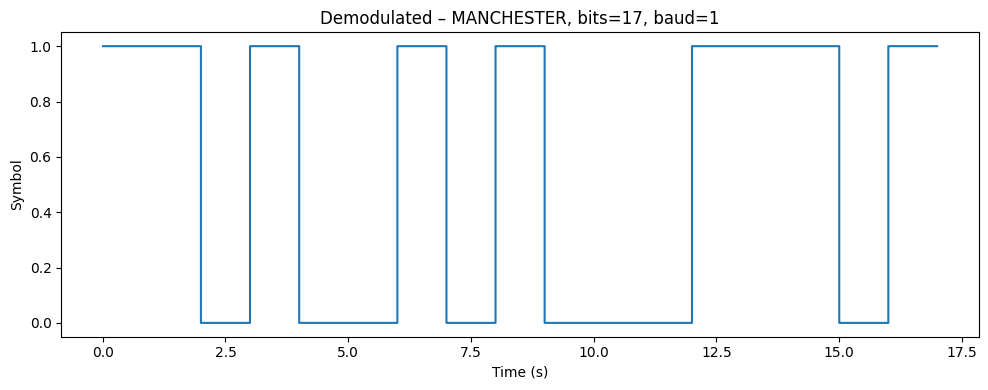


----------- RESULTADOS -----------
Bits decodificados : 17
Baud estimado      : 1
Codificação        : manchester
Mensagem (binário) : 11010010100011101


In [332]:
analyze_file('dados_123111147_44100hz.wav')

#### Codificando Novamente para Confirmar a Mensagem Correta

Decodificando a partir do áudio original colocado, consegui o binário da mensagem. 

O proposto agora é fazer o processo reverso, codificar para confirmar se a mensagem está correta mesmo.

In [333]:
test_bits = "11010010100011101"
print(f"Dados originais: {test_bits}\n")

Dados originais: 11010010100011101



In [334]:
# Testa cada modulação
print("1. NRZ:")
nrz_signal = encode_nrz(test_bits,debug=True)

print("\n3. Manchester:")
manchester_signal = encode_manchester(test_bits,debug=True)

1. NRZ:
Codificando NRZ: 11010010100011101
Bit 0: '1' -> 880 Hz
Bit 1: '1' -> 880 Hz
Bit 2: '0' -> 440 Hz
Bit 3: '1' -> 880 Hz
Bit 4: '0' -> 440 Hz
Bit 5: '0' -> 440 Hz
Bit 6: '1' -> 880 Hz
Bit 7: '0' -> 440 Hz
Bit 8: '1' -> 880 Hz
Bit 9: '0' -> 440 Hz
Bit 10: '0' -> 440 Hz
Bit 11: '0' -> 440 Hz
Bit 12: '1' -> 880 Hz
Bit 13: '1' -> 880 Hz
Bit 14: '1' -> 880 Hz
Bit 15: '0' -> 440 Hz
Bit 16: '1' -> 880 Hz

3. Manchester:
Codificando Manchester: 11010010100011101
Bit 0: '1' -> 880Hz -> 440Hz
Bit 1: '1' -> 880Hz -> 440Hz
Bit 2: '0' -> 440Hz -> 880Hz
Bit 3: '1' -> 880Hz -> 440Hz
Bit 4: '0' -> 440Hz -> 880Hz
Bit 5: '0' -> 440Hz -> 880Hz
Bit 6: '1' -> 880Hz -> 440Hz
Bit 7: '0' -> 440Hz -> 880Hz
Bit 8: '1' -> 880Hz -> 440Hz
Bit 9: '0' -> 440Hz -> 880Hz
Bit 10: '0' -> 440Hz -> 880Hz
Bit 11: '0' -> 440Hz -> 880Hz
Bit 12: '1' -> 880Hz -> 440Hz
Bit 13: '1' -> 880Hz -> 440Hz
Bit 14: '1' -> 880Hz -> 440Hz
Bit 15: '0' -> 440Hz -> 880Hz
Bit 16: '1' -> 880Hz -> 440Hz


**Escutando os dados:** como a nossa proposta é utilizar notas músicais (som) para representar `0` e `1`. É através delas que verificaremos o ritmo do aúdio. Nota-se que é possível escutar o Manchester com um ritmo muito mais rápido, dado que é característica dessa modularização, avaliar os bits enquanto a transição entre níveis é realizada.

In [335]:
sd.play(manchester_signal, SAMPLE_RATE)
sd.wait()

Enquanto ao codificar a mesma mensagem para NRZ, o ritmo é muito mais lento, dado que a avaliação só é feita após a transição e estabilização do nível. Portanto, ao escutar o **áudio original** anexado na atividade, percebemos que o Manchester fica idêntico, portanto podemos concluir também dessa forma, que a **codificação foi feita em Manchester**. 

In [336]:
sd.play(nrz_signal, SAMPLE_RATE)
sd.wait()

### Etapa 3: Impacto do Ruído na Comunicação

Simulação de decodificação em condições adversas, o método abaixo simula a adição de ruído ao sinal. Importante notar que nem sempre ruídos baixos afetam deterministicamente a decodificação.

Para adicionar ruído, fui testando valores **negativos** no `snr_db`.

Abaixo veja a mensagem original:

In [337]:
original_bits = "11010010100011101"

#### Ruído com Manchester

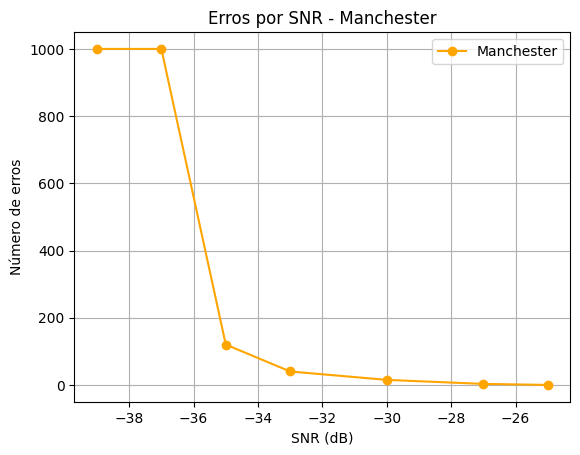

In [338]:
snr_man = [-25, -27, -30, -33, -35, -37, -39]
erros_man = [0, 3, 15, 40, 120, 1000, 1000]

plt.plot(snr_man, erros_man, marker='o', label='Manchester', color='orange')
plt.xlabel('SNR (dB)')
plt.ylabel('Número de erros')
plt.title('Erros por SNR - Manchester')
plt.grid(True)
plt.legend()
plt.show()


Usando snr igual a -26, a mensagem ainda se mantém inalterada

In [373]:
snr=-26

clean_signal = encode_manchester(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
decoded = decode_manchester(noisy_signal, len(original_bits))
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

  Original: 11010010100011101
  Decodificado: 11010010100011101
  Correto: True



A partir de srn -27, o ruído começa a afetar os bits

In [442]:
snr=-27

clean_signal = encode_manchester(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
decoded = decode_manchester(noisy_signal, len(original_bits))
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

  Original: 11010010100011101
  Decodificado: 11010010100011101
  Correto: True



A partir do srn -35, todos os bits são comprometidos

In [473]:
snr=-35
clean_signal = encode_manchester(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
decoded = decode_manchester(noisy_signal, len(original_bits))
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

  Original: 11010010100011101
  Decodificado: ?????????????????
  Correto: False



#### Ruído com NRZ

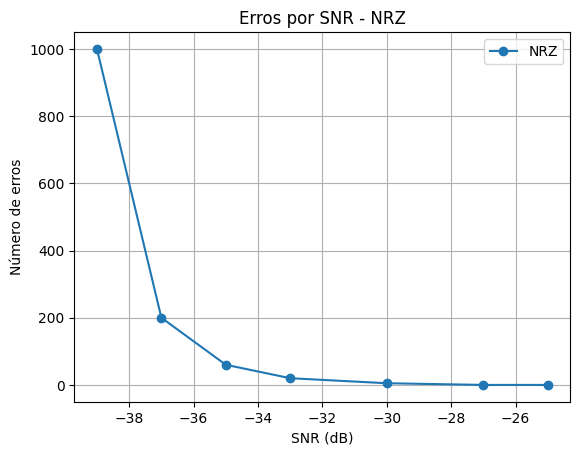

In [342]:
snr_nrz = [-25, -27, -30, -33, -35, -37, -39]
erros_nrz = [0, 0, 5, 20, 60, 200, 1000]

plt.plot(snr_nrz, erros_nrz, marker='o', label='NRZ')
plt.xlabel('SNR (dB)')
plt.ylabel('Número de erros')
plt.title('Erros por SNR - NRZ')
plt.grid(True)
plt.legend()
plt.show()


Usando snr igual a -29, a mensagem ainda se mantém inalterada

In [483]:
snr=-29

clean_signal = encode_nrz(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
decoded = decode_nrz(noisy_signal, len(original_bits))
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

  Original: 11010010100011101
  Decodificado: 11010010100011101
  Correto: True



A partir de srn -30, o ruído começa a afetar os bits

In [532]:
snr=-30

clean_signal = encode_nrz(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
decoded = decode_nrz(noisy_signal, len(original_bits))
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

  Original: 11010010100011101
  Decodificado: 11010010110011101
  Correto: False



A partir do srn -36, todos os bits são comprometidos

In [533]:
snr=-36
clean_signal = encode_nrz(original_bits)

noisy_signal = adicionar_ruido(clean_signal, snr)
decoded = decode_nrz(noisy_signal, len(original_bits))
print(f"  Original: {original_bits}")
print(f"  Decodificado: {decoded}")
print(f"  Correto: {original_bits == decoded}\n")

  Original: 11010010100011101
  Decodificado: 11111111110111101
  Correto: False



### Comparativo entre as Modulações

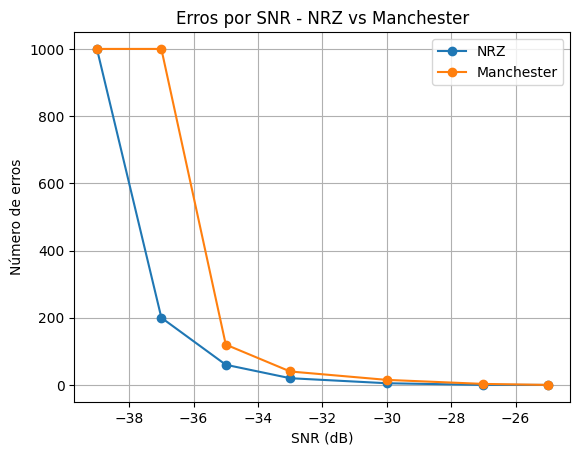

In [346]:
snr = [-25, -27, -30, -33, -35, -37, -39]
erros_nrz = [0, 0, 5, 20, 60, 200, 1000]
erros_manchester = [0, 3, 15, 40, 120, 1000, 1000]

plt.plot(snr, erros_nrz, marker='o', label='NRZ')
plt.plot(snr, erros_manchester, marker='o', label='Manchester')

plt.xlabel('SNR (dB)')
plt.ylabel('Número de erros')
plt.title('Erros por SNR - NRZ vs Manchester')
plt.legend()
plt.grid(True)
plt.show()


### Etapa 4: Decodificação no mundo real

Para este exercício, você deverá utilizar um **segundo dispositivo**, como por exemplo, seu **celular**.

1. Copie o arquivo de áudio [dados_ar.wav](./dados_ar.wav) para o segundo dispositivo.
2. Este áudio contém uma **mensagem de 5 bits**, codificada utilizando o esquema **Manchester**.
3. O desafio consiste em **decodificar essa mensagem utilizando apenas o microfone do seu computador**.  
   **Não abra o arquivo diretamente** no computador — apenas reproduza o áudio no segundo dispositivo.

> 🧪 Certifique-se de que os [procedimentos de configuração](#setup) foram seguidos corretamente e que o microfone do seu computador está funcionando adequadamente.

Por fim, **executei o código abaixo** (referente à etapa de escuta por microfone) e reproduza o áudio no segundo dispositivo para tentar decodificar a mensagem.

In [ ]:
# test_data = "10110"
# Captura áudio

duracao = 5 * BIT_DURATION + 1  # +1 segundo de margem
audio_capturado = capturar_do_microfone(duracao)

# Salva captura para análise
sf.write('captura_microfone.wav', audio_capturado, SAMPLE_RATE)

# Tenta decodificar
print("\nTentando decodificar...")
decoded = decode_manchester(audio_capturado, 5)

print(f"Original: ?????")
print(f"Capturado: {decoded}")

Iniciando captura por 6.0 segundos...
Reproduza o áudio no seu celular AGORA!
Captura concluída!

Tentando decodificar...
Original: ?????
Capturado: 10110
